### **DATA ANALYSIS FOR LAUNCHING A COMPETITIVE MOVIE STUDIO**

### INTRODUCTION

There Is a huge wave of investment in original content in the entertainment landscape. To strategically position our new studio for success, we must understand the industry's key drivers.


#### OBJECTIVES

* Explore the impact of Production Budget on Worldwide ROI and Domestic ROI
* Explore the relationship between Genre and Average Rating
* Explore the relationship between Average Runtime and Average Rating
* Explore the popular trends of different film languages over time
* Use correlation and data visualization to explore these relationships and gain insights

#### LOADING THE DATA

In [2]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sqlite3
from scipy.stats import pearsonr

%matplotlib inline

In [3]:
budgets_df = pd.read_csv('Data/tn.movie_budgets.csv', index_col='id')
budgets_df.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
gross_df = pd.read_csv('Data/bom.movie_gross.csv')
gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [5]:
info_df = pd.read_csv('Data/rt.movie_info.tsv',sep='\t')
info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


### DATA CLEANING AND MERGING


In [6]:
#checking duplicates.
budgets_df.duplicated().sum()

np.int64(0)

In [7]:
#checking for null values.
budgets_df.isnull().sum()


release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [8]:
# convert currency strings to numerical values and extract year from release dates
budgets_df['production_budget'] = budgets_df['production_budget'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
budgets_df['domestic_gross'] = budgets_df['domestic_gross'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
budgets_df['worldwide_gross'] = budgets_df['worldwide_gross'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
budgets_df['year'] = pd.to_datetime(budgets_df['release_date']).dt.year

In [9]:
# rename the 'movie' column to 'title'
budgets_df = budgets_df.rename(columns={'movie': 'title'})

In [10]:
# drop the release_date column
drop_budgets_df = ['release_date']
budgets_df = budgets_df.drop(columns=drop_budgets_df)
budgets_df.head()

,title,production_budget,domestic_gross,worldwide_gross,year
id,,,,,
1,Avatar,425000000.0,760507625.0,2.776345e+09,2009
2,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,2011
3,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,2019
4,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,2015
5,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09,2017


In [11]:
# check for duplicates
gross_df.duplicated().sum()

np.int64(0)

In [12]:
# check for missing values
gross_df.isnull().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [13]:
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [14]:
# drop rows with missing values
gross_df = gross_df.dropna()
gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   object 
 4   year            2007 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 94.1+ KB


In [15]:
gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [16]:
# check for duplicates
info_df.duplicated().sum()

np.int64(0)

In [17]:
# check for missing values
info_df.isnull().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

In [18]:
# extract year from theater date
info_df['release_year'] = pd.to_datetime(info_df['theater_date']).dt.year.astype('Int64')

In [19]:
# drop unnecessary columns
drop_info_df = ['box_office', 'currency', 'studio', 'dvd_date', 'synopsis', 'writer', 'id']
info_df = info_df.drop(columns=drop_info_df)
info_df.head()

,rating,genre,director,theater_date,runtime,release_year
0,R,Action and Adventure|Classics|Drama,William Friedkin,"Oct 9, 1971",104 minutes,1971
1,R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012",108 minutes,2012
2,R,Drama|Musical and Performing Arts,Allison Anders,"Sep 13, 1996",116 minutes,1996
3,R,Drama|Mystery and Suspense,Barry Levinson,"Dec 9, 1994",128 minutes,1994
4,NR,Drama|Romance,Rodney Bennett,NaN,200 minutes,<NA>


In [20]:
info_df = info_df.drop(columns='theater_date')

In [21]:
info_df.isnull().sum()

rating            3
genre             8
director        199
runtime          30
release_year    359
dtype: int64

In [22]:
info_df = info_df.dropna()
info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1076 entries, 0 to 1558
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   rating        1076 non-null   object
 1   genre         1076 non-null   object
 2   director      1076 non-null   object
 3   runtime       1076 non-null   object
 4   release_year  1076 non-null   Int64 
dtypes: Int64(1), object(4)
memory usage: 51.5+ KB


In [23]:
# removing whitespaces and converting title columns to lowercase
budgets_df['title'] = budgets_df['title'].str.strip().str.lower()
gross_df['title'] = gross_df['title'].str.strip().str.lower()

In [24]:
# merging budget df and gross df
budget_gross_df = pd.merge(budgets_df, gross_df,  on=['title', 'year'], how='left')
budget_gross_df

,title,production_budget,domestic_gross_x,worldwide_gross,year,studio,domestic_gross_y,foreign_gross
0,avatar,425000000.0,760507625.0,2.776345e+09,2009,NaN,NaN,NaN
1,pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011,BV,241100000.0,804600000
2,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019,NaN,NaN,NaN
3,avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,2015,BV,459000000.0,946400000
4,star wars ep. viii: the last jedi,317000000.0,620181382.0,1.316722e+09,2017,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
5777,red 11,7000.0,0.0,0.000000e+00,2018,NaN,NaN,NaN
5778,following,6000.0,48482.0,2.404950e+05,1999,NaN,NaN,NaN
5779,return to the land of wonders,5000.0,1338.0,1.338000e+03,2005,NaN,NaN,NaN
5780,a plague so pleasant,1400.0,0.0,0.000000e+00,2015,NaN,NaN,NaN


In [25]:
budget_gross_df.isnull().sum()

title                   0
production_budget       0
domestic_gross_x        0
worldwide_gross         0
year                    0
studio               4686
domestic_gross_y     4686
foreign_gross        4686
dtype: int64

In [26]:
drop_budget_gross_df = ['domestic_gross_y', 'foreign_gross', 'studio']
budget_gross_df = budget_gross_df.drop(columns=drop_budget_gross_df)

In [27]:
budget_gross_df = budget_gross_df.reset_index(drop=True)

In [28]:
zero_rows = budget_gross_df[budget_gross_df['domestic_gross_x'] == 0]
zero_rows

,title,production_budget,domestic_gross_x,worldwide_gross,year
194,moonfall,150000000.0,0.0,0.0,2020
479,bright,90000000.0,0.0,0.0,2017
480,army of the dead,90000000.0,0.0,0.0,2019
535,call of the wild,82000000.0,0.0,0.0,2020
617,astã©rix et obã©lix: au service de sa majestã©,77600000.0,0.0,60680125.0,2012
...,...,...,...,...,...
5761,stories of our lives,15000.0,0.0,0.0,2014
5764,tin can man,12000.0,0.0,0.0,2007
5771,family motocross,10000.0,0.0,0.0,2015
5777,red 11,7000.0,0.0,0.0,2018


In [29]:
budget_gross_df = budget_gross_df[budget_gross_df['domestic_gross_x'] != 0]

In [30]:
budget_gross_df = budget_gross_df[budget_gross_df['production_budget'] != 0]

In [31]:
budget_gross_df = budget_gross_df.rename(columns={'domestic_gross_x': 'domestic_gross'})

In [32]:
budget_gross_df =budget_gross_df.reset_index(drop=True)
budget_gross_df

,title,production_budget,domestic_gross,worldwide_gross,year
0,avatar,425000000.0,760507625.0,2.776345e+09,2009
1,pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011
2,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019
3,avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,2015
4,star wars ep. viii: the last jedi,317000000.0,620181382.0,1.316722e+09,2017
...,...,...,...,...,...
5229,cavite,7000.0,70071.0,7.164400e+04,2006
5230,the mongol king,7000.0,900.0,9.000000e+02,2004
5231,following,6000.0,48482.0,2.404950e+05,1999
5232,return to the land of wonders,5000.0,1338.0,1.338000e+03,2005


In [33]:
zip_file = 'Data/im.db.zip'
extracted_file = 'im.db'

# unzip the file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

# create connection to database
conn = sqlite3.connect(extracted_file)
cursor = conn.cursor()

In [34]:
# check the table names of the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [35]:
query_1 = '''
SELECT *
FROM movie_basics
LIMIT 5;
'''

pd.read_sql(query_1, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [36]:
# retrieve movie titles, genres and average ratings
query_2 = '''
SELECT mb.primary_title as title, mb.genres, mr.averagerating
FROM movie_basics AS mb
JOIN movie_ratings AS mr 
ON mb.movie_id = mr.movie_id
ORDER BY mr.averagerating DESC;
'''

genre_df = pd.read_sql(query_2, conn)
genre_df

,title,genres,averagerating
0,Exteriores: Mulheres Brasileiras na Diplomacia,Documentary,10.0
1,The Dark Knight: The Ballad of the N Word,"Comedy,Drama",10.0
2,Freeing Bernie Baran,"Crime,Documentary",10.0
3,Hercule contre Hermès,Documentary,10.0
4,I Was Born Yesterday!,Documentary,10.0
...,...,...,...
73851,La Scelta Impossibile,Drama,1.0
73852,Overdose of Gore: Crime born Crime,Horror,1.0
73853,Roofied: The Lethal Dose,Drama,1.0
73854,The Defender,Drama,1.0


In [37]:
genre_df['genres'] = genre_df['genres'].str.split(',')
genre_df = genre_df.explode('genres')

In [38]:
genre_counts = genre_df.groupby('genres').agg(
    count=('genres', 'count'),
    avg_rating=('averagerating', 'mean')).reset_index()
genre_counts = genre_counts.sort_values(by=['count', 'avg_rating'], ascending=[False, False])

In [39]:
genre_counts = genre_counts.reset_index(drop=True)
genre_counts

,genres,count,avg_rating
0,Drama,30788,6.401559
1,Documentary,17753,7.332090
2,Comedy,17290,6.002689
3,Thriller,8217,5.639114
4,Horror,7674,5.003440
5,Action,6988,5.810361
6,Romance,6589,6.146608
7,Crime,4611,6.115441
8,Adventure,3817,6.196201
9,Biography,3809,7.162274


In [40]:
# retrieve genres and runtime
query_3 = '''
SELECT genres, runtime_minutes AS runtime
FROM movie_basics;
'''
genre_runtime_df = pd.read_sql(query_3, conn)
genre_runtime_df

,genres,runtime
0,"Action,Crime,Drama",175.0
1,"Biography,Drama",114.0
2,Drama,122.0
3,"Comedy,Drama",NaN
4,"Comedy,Drama,Fantasy",80.0
...,...,...
146139,Drama,123.0
146140,Documentary,NaN
146141,Comedy,NaN
146142,None,116.0


In [41]:
genre_runtime_df['genres'] = genre_runtime_df['genres'].str.split(',')
genre_runtime_df = genre_runtime_df.explode('genres')

In [42]:
genre_runtime_df['runtime'] = pd.to_numeric(genre_runtime_df['runtime']) 

In [43]:
genre_runtime_counts = genre_runtime_df.groupby('genres').agg(
    count=('genres', 'count'),
    avg_runtime=('runtime', 'mean')).reset_index()
genre_runtime_counts = genre_runtime_counts.sort_values(by=['count', 'avg_runtime'], ascending=[False, False])

In [44]:
genre_runtime_counts = genre_runtime_counts.reset_index(drop=True)
genre_runtime_counts

,genres,count,avg_runtime
0,Documentary,51640,72.107879
1,Drama,49883,94.281372
2,Comedy,25312,93.920165
3,Thriller,11883,94.351337
4,Horror,10805,87.351383
5,Action,10335,100.019729
6,Romance,9372,100.219710
7,Biography,8722,74.129960
8,Crime,6753,95.508631
9,Adventure,6465,85.782404


In [45]:
genres_df = pd.merge(genre_counts, genre_runtime_counts, on='genres')

genres_df = genres_df.drop(['count_x', 'count_y'], axis=1)
genres_df.head()

,genres,avg_rating,avg_runtime
0,Drama,6.401559,94.281372
1,Documentary,7.332090,72.107879
2,Comedy,6.002689,93.920165
3,Thriller,5.639114,94.351337
4,Horror,5.003440,87.351383


In [46]:
# retrieve director names, average rating and movie count
query_4 = '''
SELECT p.primary_name AS director_name, AVG(mr.averagerating) AS average_rating, COUNT(DISTINCT d.movie_id) AS movie_count
FROM directors d
JOIN persons p 
ON d.person_id = p.person_id
JOIN movie_ratings mr ON d.movie_id = mr.movie_id
GROUP BY p.primary_name
HAVING COUNT(DISTINCT d.movie_id) > 3
ORDER BY movie_count DESC,  average_rating DESC;
'''
pd.read_sql(query_4, conn)

,director_name,average_rating,movie_count
0,Sergey A.,7.129630,39
1,Nayato Fio Nuala,4.885417,37
2,Larry Rosen,6.754545,34
3,Dustin Ferguson,4.746226,31
4,Jason Impey,5.339444,30
...,...,...,...
2994,Ján Novák,2.833333,4
2995,Daisuke Yamanouchi,2.650000,4
2996,Jerry Burkhead,2.228571,4
2997,Andrew Bellware,2.087500,4


In [47]:
query_5 = '''
SELECT ma.language, mb.start_year
FROM movie_akas AS ma
JOIN movie_basics AS mb 
ON ma.movie_id = mb.movie_id;
'''

language_df = pd.read_sql(query_5, conn)
language_df = language_df.dropna()
language_df.reset_index(drop=True)

,language,start_year
0,bg,2015
1,he,2015
2,fr,2015
3,tr,2015
4,tr,2015
...,...,...
41710,en,2019
41711,yue,2019
41712,yue,2019
41713,en,2019


### EXPLORATORY DATA ANALYSIS

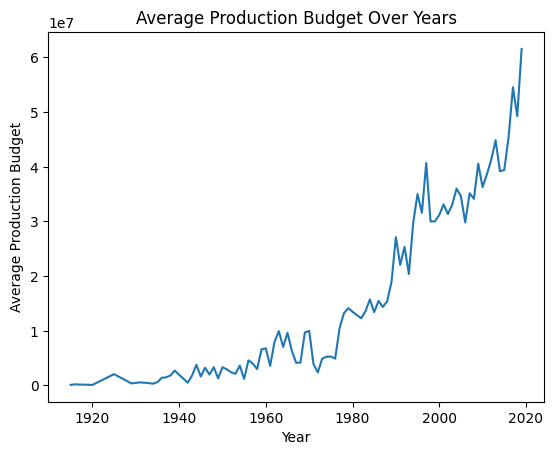

In [48]:
# how has the production budget changed over the years
yearly_budget = budget_gross_df.groupby('year')['production_budget'].mean()
years = yearly_budget.index
budgets = yearly_budget.values

fig, ax = plt.subplots()  

ax.plot(years, budgets, linestyle='-')
ax.set_title('Average Production Budget Over Years')
ax.set_xlabel('Year')
ax.set_ylabel('Average Production Budget');


plt.show()

* There is a significant increase in production budget over the years means the film industry is on the rise hence signaling a period of potential financial gains

In [49]:
budget_gross_df.loc[:, 'profit'] = budget_gross_df['worldwide_gross'] - budget_gross_df['production_budget']

In [50]:
profit_by_year = budget_gross_df.groupby('year')['profit'].sum().reset_index()

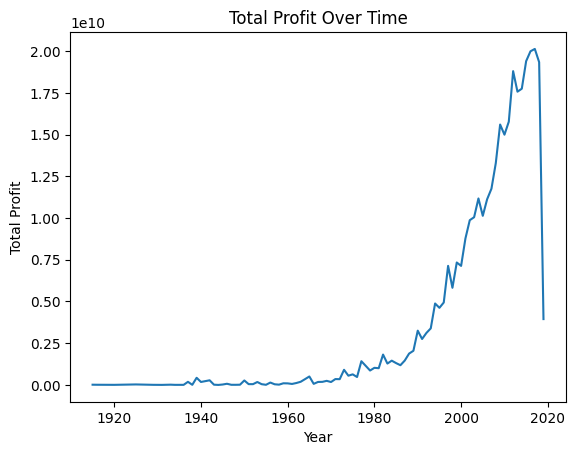

In [51]:
fig, ax = plt.subplots()

sns.lineplot(x='year', y='profit', data=profit_by_year, ax=ax)

ax.set_title('Total Profit Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Total Profit')

plt.show()

* The film industry profitability over time highlights period of growth then decline

In [52]:
# summary statistics
budget_gross_df.describe()

,production_budget,domestic_gross,worldwide_gross,year,profit
count,5.234000e+03,5.234000e+03,5.234000e+03,5234.000000,5.234000e+03
mean,3.403348e+07,4.625747e+07,1.007615e+08,2003.308942,6.672803e+07
std,4.296048e+07,7.029651e+07,1.811226e+08,12.619158,1.518522e+08
min,1.100000e+03,3.880000e+02,4.010000e+02,1915.000000,-2.002376e+08
25%,6.500000e+06,4.289718e+06,8.142571e+06,1999.000000,-1.396634e+06
50%,2.000000e+07,2.198422e+07,3.543844e+07,2006.000000,1.357260e+07
75%,4.500000e+07,5.756598e+07,1.093357e+08,2012.000000,7.088258e+07
max,4.250000e+08,9.366622e+08,2.776345e+09,2019.000000,2.351345e+09


In [53]:
# domestic return on investment
budget_gross_df['domestic_profit'] = budget_gross_df['domestic_gross'] - budget_gross_df['production_budget']

budget_gross_df['domestic_roi'] = (budget_gross_df['domestic_profit'] / budget_gross_df['production_budget']) * 100

# worldwide return on investment
budget_gross_df['worldwide_profit'] = budget_gross_df['worldwide_gross'] - budget_gross_df['production_budget']

budget_gross_df['worldwide_roi'] = (budget_gross_df['worldwide_profit'] / budget_gross_df['production_budget']) * 100


In [54]:
budget_gross_df

,title,production_budget,domestic_gross,worldwide_gross,year,profit,domestic_profit,domestic_roi,worldwide_profit,worldwide_roi
0,avatar,425000000.0,760507625.0,2.776345e+09,2009,2.351345e+09,335507625.0,78.942971,2.351345e+09,553.257713
1,pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011,6.350639e+08,-169536125.0,-41.289850,6.350639e+08,154.667286
2,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019,-2.002376e+08,-307237650.0,-87.782186,-2.002376e+08,-57.210757
3,avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,2015,1.072414e+09,128405868.0,38.840250,1.072414e+09,324.384139
4,star wars ep. viii: the last jedi,317000000.0,620181382.0,1.316722e+09,2017,9.997217e+08,303181382.0,95.640815,9.997217e+08,315.369636
...,...,...,...,...,...,...,...,...,...,...
5229,cavite,7000.0,70071.0,7.164400e+04,2006,6.464400e+04,63071.0,901.014286,6.464400e+04,923.485714
5230,the mongol king,7000.0,900.0,9.000000e+02,2004,-6.100000e+03,-6100.0,-87.142857,-6.100000e+03,-87.142857
5231,following,6000.0,48482.0,2.404950e+05,1999,2.344950e+05,42482.0,708.033333,2.344950e+05,3908.250000
5232,return to the land of wonders,5000.0,1338.0,1.338000e+03,2005,-3.662000e+03,-3662.0,-73.240000,-3.662000e+03,-73.240000


In [55]:
# remove outliers from domestic roi
q1 = budget_gross_df['domestic_roi'].quantile(0.25)
q3 = budget_gross_df['domestic_roi'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3+ 1.5 * iqr
budget_gross_df = budget_gross_df[(budget_gross_df['domestic_roi'] >= lower_bound) & (budget_gross_df['domestic_roi'] <= upper_bound)]
budget_gross_df

,title,production_budget,domestic_gross,worldwide_gross,year,profit,domestic_profit,domestic_roi,worldwide_profit,worldwide_roi
0,avatar,425000000.0,760507625.0,2.776345e+09,2009,2.351345e+09,335507625.0,78.942971,2.351345e+09,553.257713
1,pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011,6.350639e+08,-169536125.0,-41.289850,6.350639e+08,154.667286
2,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019,-2.002376e+08,-307237650.0,-87.782186,-2.002376e+08,-57.210757
3,avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,2015,1.072414e+09,128405868.0,38.840250,1.072414e+09,324.384139
4,star wars ep. viii: the last jedi,317000000.0,620181382.0,1.316722e+09,2017,9.997217e+08,303181382.0,95.640815,9.997217e+08,315.369636
...,...,...,...,...,...,...,...,...,...,...
5224,bang,10000.0,527.0,5.270000e+02,1996,-9.473000e+03,-9473.0,-94.730000,-9.473000e+03,-94.730000
5225,the rise and fall of miss thang,10000.0,401.0,4.010000e+02,2008,-9.599000e+03,-9599.0,-95.990000,-9.599000e+03,-95.990000
5226,newlyweds,9000.0,4584.0,4.584000e+03,2012,-4.416000e+03,-4416.0,-49.066667,-4.416000e+03,-49.066667
5230,the mongol king,7000.0,900.0,9.000000e+02,2004,-6.100000e+03,-6100.0,-87.142857,-6.100000e+03,-87.142857


In [56]:
# correlation
correlation, p_value = pearsonr(budget_gross_df['production_budget'], budget_gross_df['domestic_roi'])
correlation

np.float64(-0.022982698776579893)

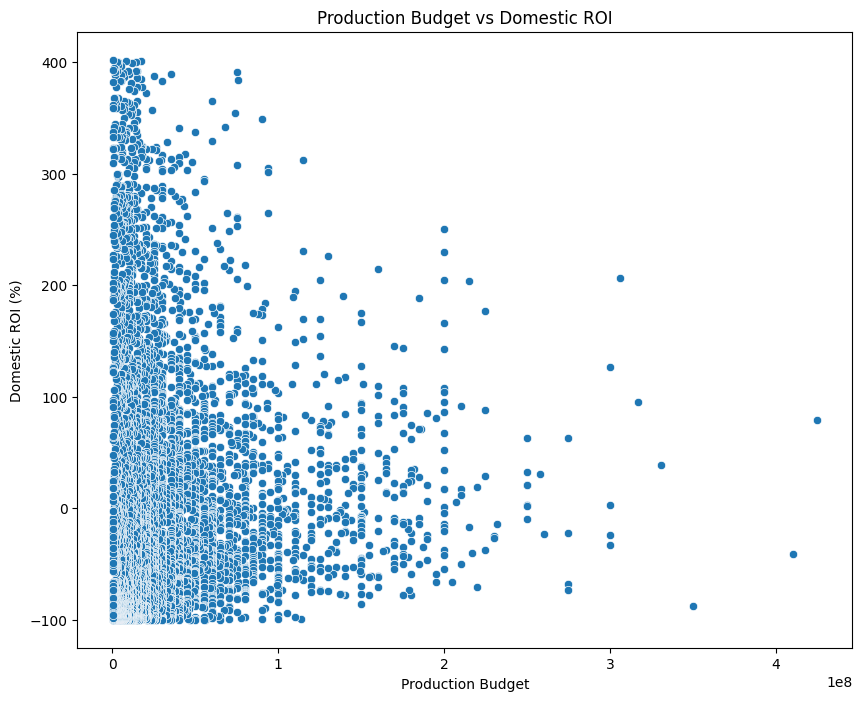

In [57]:
# 
plt.figure(figsize=(10, 8))
sns.scatterplot(x='production_budget', y='domestic_roi', data=budget_gross_df)
plt.title('Production Budget vs Domestic ROI')
plt.xlabel('Production Budget')
plt.ylabel('Domestic ROI (%)');
plt.show()

In [58]:
# scatter plot of films with a production budget of less than 1.5 million
budget_gross_df_1 = budget_gross_df[budget_gross_df['production_budget'] < 150000000]

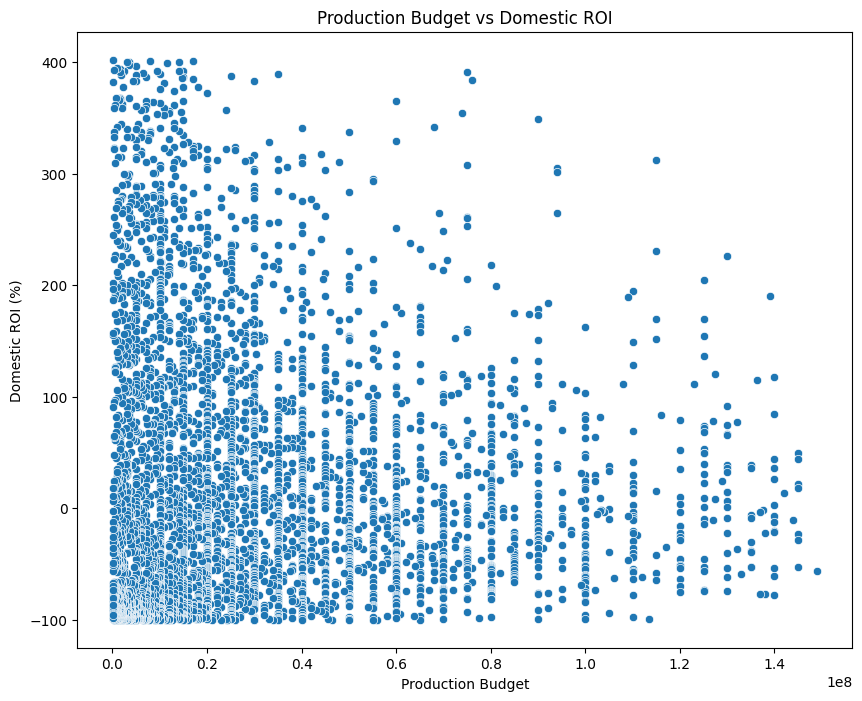

In [59]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='production_budget', y='domestic_roi', data=budget_gross_df_1)
plt.title('Production Budget vs Domestic ROI')
plt.xlabel('Production Budget')
plt.ylabel('Domestic ROI (%)')
plt.show()

* A weak negative correlation meaning there is a slight tendency of domestic ROI decreasing when production budget increases but the relationship is very weak.

In [60]:
# remove outliers from worldwide roi
q1 = budget_gross_df['worldwide_roi'].quantile(0.25)
q3 = budget_gross_df['worldwide_roi'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3+ 1.5 * iqr
budget_gross_df = budget_gross_df[(budget_gross_df['worldwide_roi'] >= lower_bound) & (budget_gross_df['worldwide_roi'] <= upper_bound)]
budget_gross_df

,title,production_budget,domestic_gross,worldwide_gross,year,profit,domestic_profit,domestic_roi,worldwide_profit,worldwide_roi
0,avatar,425000000.0,760507625.0,2.776345e+09,2009,2.351345e+09,335507625.0,78.942971,2.351345e+09,553.257713
1,pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,2011,6.350639e+08,-169536125.0,-41.289850,6.350639e+08,154.667286
2,dark phoenix,350000000.0,42762350.0,1.497624e+08,2019,-2.002376e+08,-307237650.0,-87.782186,-2.002376e+08,-57.210757
3,avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,2015,1.072414e+09,128405868.0,38.840250,1.072414e+09,324.384139
4,star wars ep. viii: the last jedi,317000000.0,620181382.0,1.316722e+09,2017,9.997217e+08,303181382.0,95.640815,9.997217e+08,315.369636
...,...,...,...,...,...,...,...,...,...,...
5224,bang,10000.0,527.0,5.270000e+02,1996,-9.473000e+03,-9473.0,-94.730000,-9.473000e+03,-94.730000
5225,the rise and fall of miss thang,10000.0,401.0,4.010000e+02,2008,-9.599000e+03,-9599.0,-95.990000,-9.599000e+03,-95.990000
5226,newlyweds,9000.0,4584.0,4.584000e+03,2012,-4.416000e+03,-4416.0,-49.066667,-4.416000e+03,-49.066667
5230,the mongol king,7000.0,900.0,9.000000e+02,2004,-6.100000e+03,-6100.0,-87.142857,-6.100000e+03,-87.142857


In [61]:
# correlation
correlation, p_value = pearsonr(budget_gross_df['production_budget'], budget_gross_df['worldwide_roi'])
correlation

np.float64(0.2092211325402092)

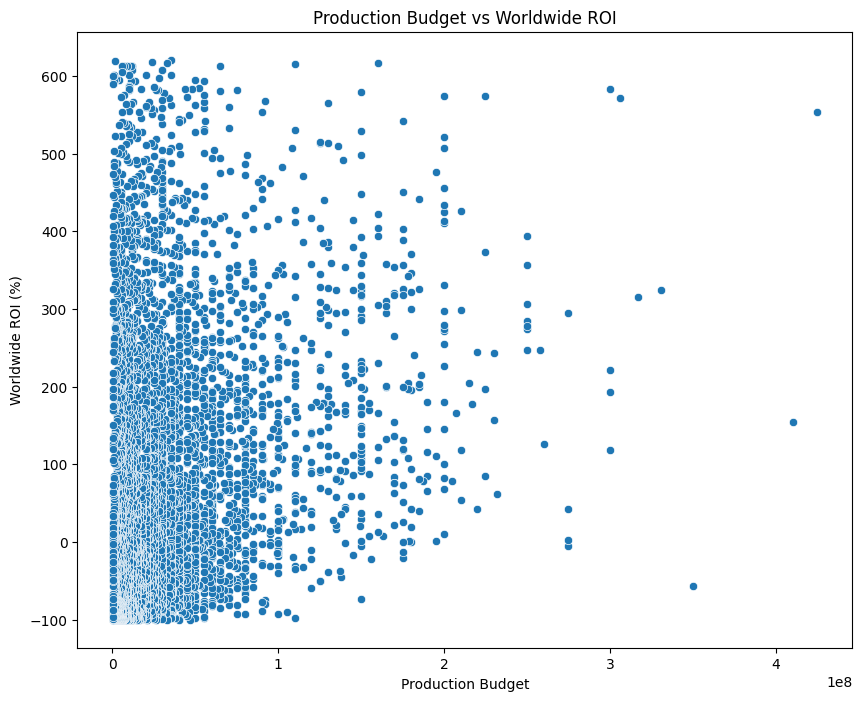

In [62]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='production_budget', y='worldwide_roi', data=budget_gross_df)
plt.title('Production Budget vs Worldwide ROI')
plt.xlabel('Production Budget')
plt.ylabel('Worldwide ROI (%)')
plt.show()

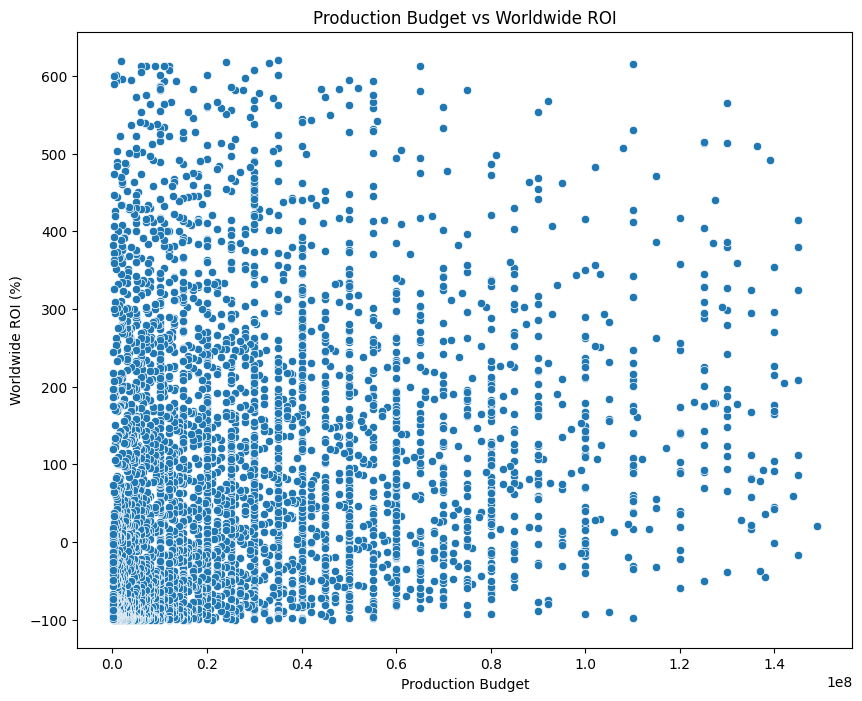

In [63]:
budget_gross_df_2 = budget_gross_df[budget_gross_df['production_budget'] < 150000000]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='production_budget', y='worldwide_roi', data=budget_gross_df_2)
plt.title('Production Budget vs Worldwide ROI')
plt.xlabel('Production Budget')
plt.ylabel('Worldwide ROI (%)')
plt.show()

* A weak positive correlation meaning there is a slight tendency of worldwide ROI increasing as production budget increases

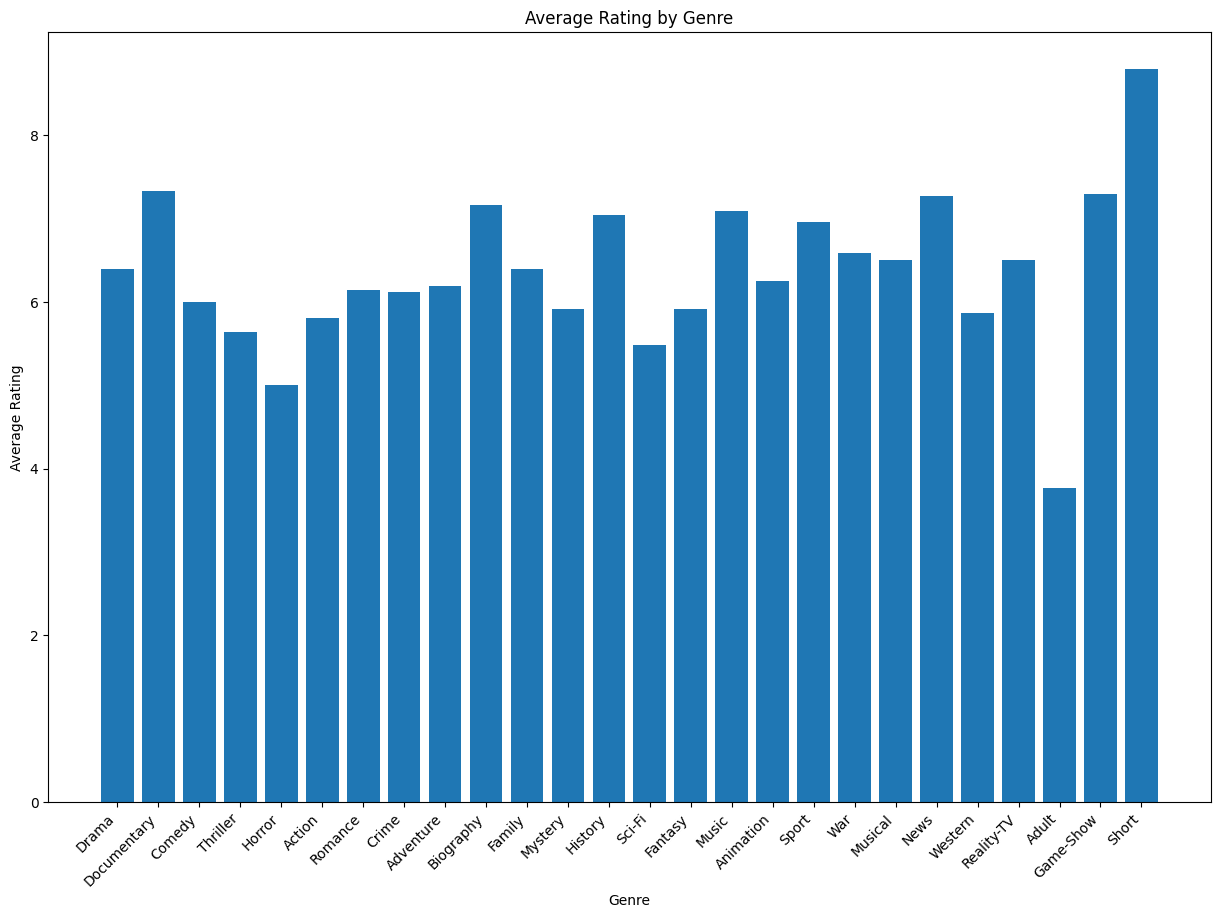

In [64]:
#
fig, ax = plt.subplots(figsize=(15, 10))

ax.bar(genre_counts['genres'], genre_counts['avg_rating'])
ax.set_title('Average Rating by Genre')
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')

ax.set_xticks(range(len(genre_counts['genres'])))
ax.set_xticklabels(genre_counts['genres'], rotation=45, ha='right')


plt.show()

* Documentaries has the highest ratings meaning it would be a safe investment but shorts would be a niche market to invest in as it is an untapped market.

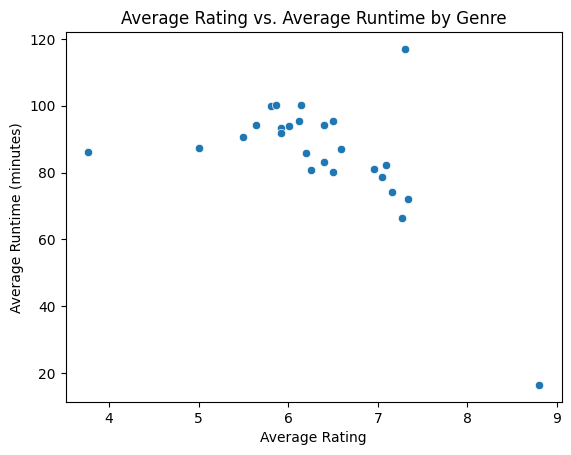

In [65]:
plt.figure()
sns.scatterplot(x='avg_rating', y='avg_runtime', data=genres_df)
plt.title('Average Rating vs. Average Runtime by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Average Runtime (minutes)');

plt.show()


In [66]:
# correlation
correlation, p_value = pearsonr(genres_df['avg_rating'], genres_df['avg_runtime'])
correlation

np.float64(-0.5636283927274777)

* Genres with high average runtimes tend to have a smaller average ratings but the correlation is weak

In [67]:
language_df['language'].value_counts().head(10)

language
en     22895
tr      3847
bg      3609
fr      3576
he      2680
sv       965
cmn      727
fa       482
hi       307
yue      286
Name: count, dtype: int64

In [68]:
language_names = {
    'en': 'English',
    'tr': 'Turkish',
    'bg': 'Bulgarian',
    'fr': 'French',
    'he': 'Hebrew',
    'sv': 'Swedish',
    'cmn': 'Mandarin Chinese',
    'fa': 'Persian (Farsi)',
    'hi': 'Hindi',
    'yue': 'Cantonese Chinese'
}

language_df['language'] = language_df['language'].map(language_names)
language_df

,language,start_year
0,Bulgarian,2015
8,Hebrew,2015
19,French,2015
27,Turkish,2015
36,Turkish,2015
...,...,...
331683,English,2019
331691,Cantonese Chinese,2019
331693,Cantonese Chinese,2019
331699,English,2019


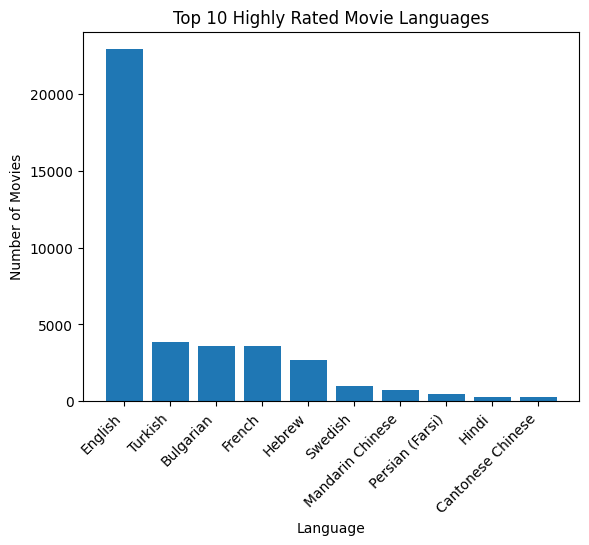

In [69]:
top_ten_languages = language_df['language'].value_counts().head(10)

fig, ax = plt.subplots()

ax.bar(top_ten_languages.index, top_ten_languages.values)
ax.set_title('Top 10 Highly Rated Movie Languages')
ax.set_xlabel('Language')
ax.set_ylabel('Number of Movies')

ax.set_xticks(range(len(top_ten_languages.index)))
ax.set_xticklabels(top_ten_languages.index, rotation=45, ha='right')


plt.show()

* The overwhelming prevalence of English movies indicates a likely demand for films in less represented languages, pointing to a potentially profitable niche market.

In [70]:
language_df = language_df[language_df['start_year'] <= 2025]

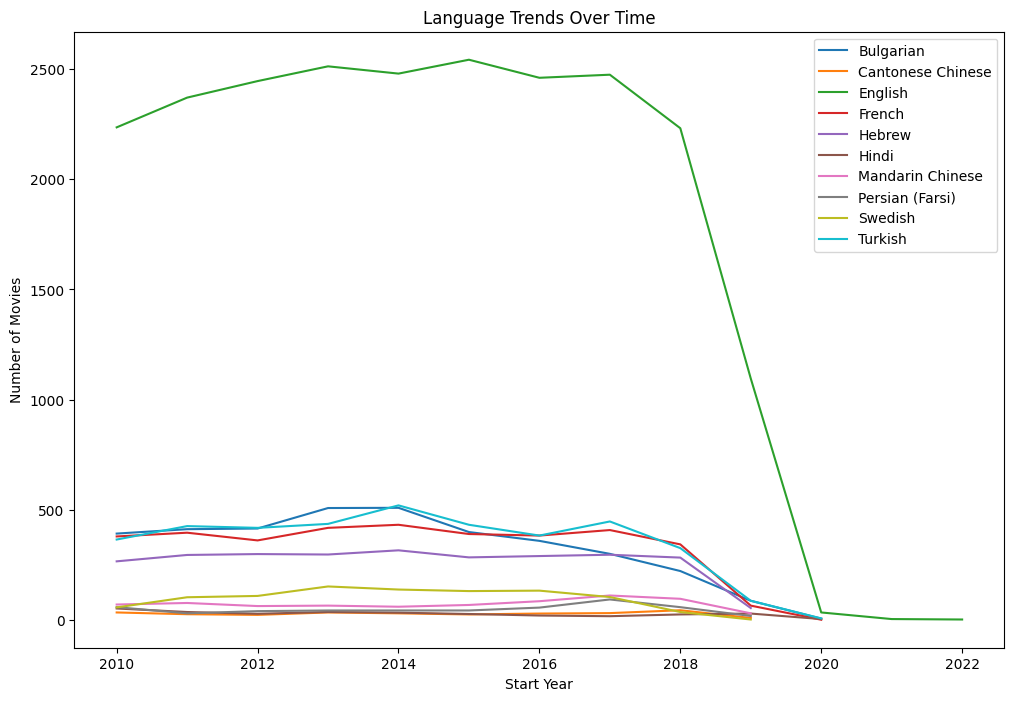

In [71]:
year_language_trend = language_df.groupby(['start_year', 'language']).size().unstack()

fig, ax = plt.subplots(figsize=(12, 8))

for language in year_language_trend.columns:
    ax.plot(year_language_trend.index, year_language_trend[language], label=language)

ax.set_title('Language Trends Over Time')
ax.set_xlabel('Start Year')
ax.set_ylabel('Number of Movies')
ax.legend()

plt.show()

* English language films dominate the data but a notable decline occurs around 2019.

### Conclusion

Despite rising budgets, film profitability is inconsistent. Domestic ROI slightly decreases with higher budgets, while worldwide ROI sees a marginal increase, though both correlations are weak. To understand long-term trends and validate these findings, it is crucial to incorporate data from recent years.
